In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

Requirements: df with the columns: Patient, Sample, cdr3pep and freq

In [2]:
chain = "IGH"
excel_file = "VASAseq-CDR3-" + chain + ".xlsx"
clones_file = excel_file.replace(".xlsx", "-clones.xlsx")
count_cdr3_barcodes_file = excel_file.replace(".xlsx", "-count-cdr3-barcodes.xlsx")
plotfile = excel_file.replace(".xlsx", ".pdf")
suspects_list = excel_file.replace(".xlsx", ".txt")
mydir = "VASAseq/"
myfiles = [x for x in os.listdir(mydir) if chain in x]
myfiles[:10]

['TCTCACAC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'TGGCTTCA_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GCTTCTTC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'ATGAGCAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'CGTAGAAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GCGTATAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'ACGAACAC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'TTCAGCGT_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GACAAACC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'CCTCTCAA_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv']

In [3]:
# Read well positions and barcodes
df_wells = pd.read_excel("/home/barbera/Downloads/VASAseq/celseq2_primers.xlsx")
df_wells = df_wells.rename(columns={'Well Position': 'Patient', 'Cell Barcode': 'Sample'})
cols = ['Patient', 'Sample']
df_wells = df_wells[cols]
df_wells.head()

,Patient,Sample
0,A1,CGTCTAAT
1,A2,AGACTCGT
2,A3,GCACGTCA
3,A4,TCAACGAC
4,A5,ATTTAGCG


In [4]:
def readCdr3File(f):
    barcode = f.split("/")[-1].split("_")[0]
    df_cdr3 = pd.read_csv(f, sep="\t", header=None)
    df_cdr3 = df_cdr3.rename(columns={0: "freq", 4: "cdr3pep"})
    df = df_cdr3.groupby("cdr3pep").agg({'freq': 'nunique'})
    df = df.reset_index()
    df["Sample"] = barcode
    return(df)

f = mydir + myfiles[0]
df = readCdr3File(f)
df.head()

,cdr3pep,freq,Sample
0,CARGAVSLTVTPRGYFDLW,1,TCTCACAC
1,CARGSGSLTVTPRGYFDLW,1,TCTCACAC
2,CARGSVSLTATPRGYFDLW,1,TCTCACAC
3,CARGSVSLTVTPRGYCDLW,1,TCTCACAC
4,CARGSVSLTVTPRGYFDLW,10,TCTCACAC


In [5]:
for f in myfiles[1:]:
    f = mydir + f
    df = pd.concat([df, readCdr3File(f)], ignore_index=True)
df.tail()

,cdr3pep,freq,Sample
3068,CARLGYDSSGYYYGELYFDYW,1,CGGTAATC
3069,CARHSWYTSGWPSDYW,1,ATCGACGA
3070,CARPTDSSAYPYYSEYW,3,TGATCGGT
3071,CARHSWYTSGWPSDYW,1,GTTCTTGC
3072,CATRGYCSGASCYKVYYYGMDVW,4,GGGGATTT


In [6]:
df = df.merge(df_wells, how="left", on="Sample")
df.head()

,cdr3pep,freq,Sample,Patient
0,CARGAVSLTVTPRGYFDLW,1,TCTCACAC,A10
1,CARGSGSLTVTPRGYFDLW,1,TCTCACAC,A10
2,CARGSVSLTATPRGYFDLW,1,TCTCACAC,A10
3,CARGSVSLTVTPRGYCDLW,1,TCTCACAC,A10
4,CARGSVSLTVTPRGYFDLW,10,TCTCACAC,A10


In [7]:
df.to_excel(clones_file)
print("Wrote", clones_file, "to disk")

Wrote VASAseq-CDR3-IGH-clones.xlsx to disk


In [8]:
# Export table with CDR3s and number of barcodes they occur in
concatValues = lambda x: ",".join(x)
df_grouped = df.groupby("cdr3pep").agg({'Patient': [concatValues, 'nunique']})
df_grouped = df_grouped.reset_index()
df_grouped = df_grouped.sort_values(by = ('Patient', 'nunique'), ascending=False)
df_grouped.head()

cdr3pep                                            Patient  \
                                                                 <lambda>   
1933   CASFLGGQWLQFDYW  F9,A21,L5,J6,O4,K9,A9,I23,H13,H15,F16,I2,L13,A...   
1763   CARVKEYDFGGMDVW  D20,A15,D21,M5,K8,I12,N5,K12,F23,A13,F17,P4,K3...   
1022  CARHSWYTSGWPSDYW  N22,F9,P8,A21,K9,I14,K13,D21,F16,K8,I7,I12,F7,...   
2271  CATDGSTVTTGFLGYW  N11,K13,D23,F17,G12,I22,O18,C21,H17,G1,L16,F12...   
474    CARGGYNRRREFDYW  O7,D12,K12,P7,E8,C6,D19,K6,E3,O5,J11,K23,M15,C...   

              
     nunique  
1933      50  
1763      37  
1022      34  
2271      19  
474       18

In [9]:
df_grouped.to_excel(count_cdr3_barcodes_file)
print("Wrote", count_cdr3_barcodes_file, "to disk")

Wrote VASAseq-CDR3-IGH-count-cdr3-barcodes.xlsx to disk


## Determine distance between samples

In [10]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient,A10,A11,A12,A13,A15,A16,A18,A21,A5,A6,...,P13,P14,P16,P19,P2,P4,P5,P7,P8,P9
Sample,TCTCACAC,TACTGGTA,ACGATAGG,GATGTCGA,CACAGCAT,CTTTGACA,GAGTCCTG,GGACCTTT,ATTTAGCG,ATACAGAC,...,CAATGGTC,AACCGGAA,TTAGGCAG,CAGAGAAG,ATCGACGA,CCCTAGTA,CCTTTGAC,GCGATATC,ACGAACAC,TTGATGGC
cdr3pep,,,,,,,,,,,,,,,,,,,,,
AARHPWYTSGGPPDYW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AASFSWGQWLQFDYW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATRFLDWQSLHFDYW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAADGSTATTGFLGYW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

,Patient,A10,A11,A12,A13,A15,A16,A18,A21,A5,A6,...,P13,P14,P16,P19,P2,P4,P5,P7,P8,P9
,Sample,TCTCACAC,TACTGGTA,ACGATAGG,GATGTCGA,CACAGCAT,CTTTGACA,GAGTCCTG,GGACCTTT,ATTTAGCG,ATACAGAC,...,CAATGGTC,AACCGGAA,TTAGGCAG,CAGAGAAG,ATCGACGA,CCCTAGTA,CCTTTGAC,GCGATATC,ACGAACAC,TTGATGGC
Patient,Sample,,,,,,,,,,,,,,,,,,,,,
A10,TCTCACAC,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
A11,TACTGGTA,0.0,1.0,0.0,0.000000,0.000000,0.009569,0.000000,0.0,0.0,0.0,...,0.0,0.0125,0.000000,0.0,0.0,0.012346,0.0,0.000000,0.012422,0.000000
A12,ACGATAGG,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
A13,GATGTCGA,0.0,0.0,0.0,1.000000,0.333333,0.000000,0.250000,0.0,0.0,0.0,...,0.0,0.0000,0.400000,0.0,0.0,0.222222,0.0,0.285714,0.000000,0.400000
A15,CACAGCAT,0.0,0.0,0.0,0.333333,1.000000,0.000000,0.333333,0.0,0.0,0.0,...,0.0,0.0000,0.666667,0.0,0.0,0.285714,0.0,0.800000,0.000000,0.666667


In [12]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote VASAseq-CDR3-IGH.xlsx to disk


## Create a heatmap

In [13]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [14]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 0.0002674869600106655
max value: 1.0
Wrote VASAseq-CDR3-IGH.pdf to disk


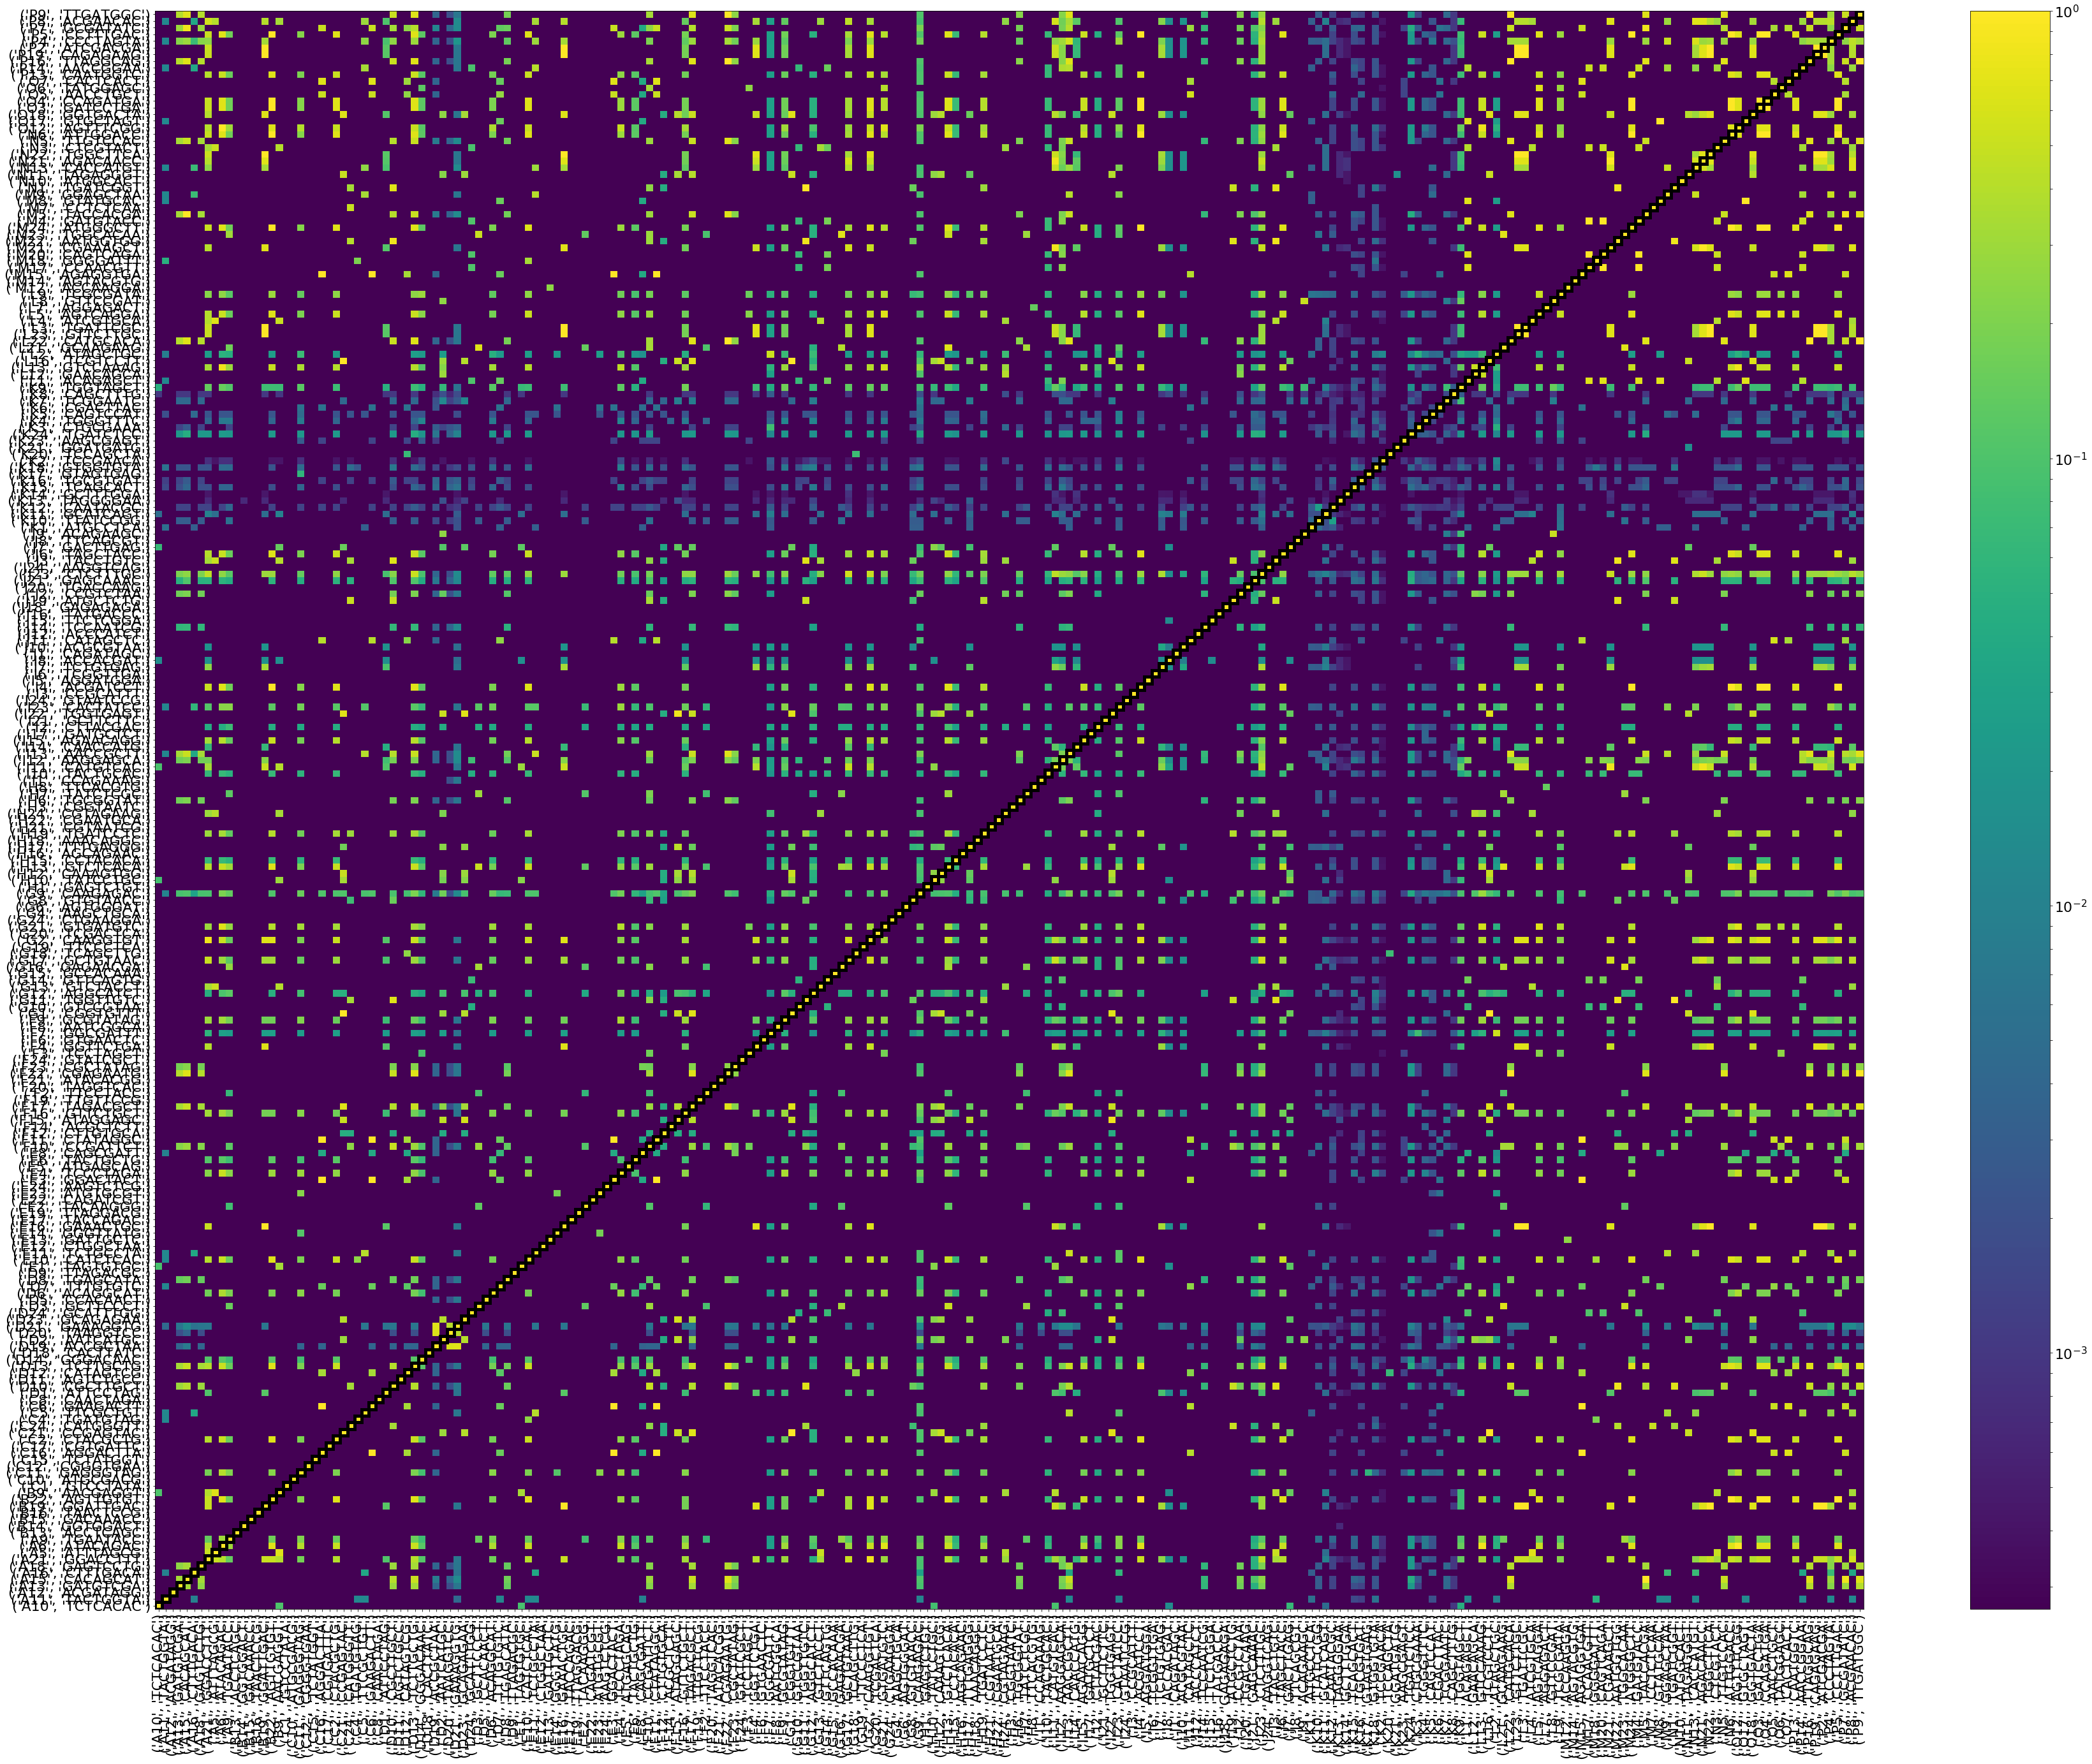

In [15]:
drawHeatmap(sim)

## Highlight anomalies

In [16]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [17]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient nan nan
mean diff patient 0.020283598678651087 0.09486345253229568
threshold 0.3997374088078338


/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'boxes': [<matplotlib.lines.Line2D at 0x7f26e3d61a58>,
 'caps': [<matplotlib.lines.Line2D at 0x7f26e3d694a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f26e3d73160>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f26e3d69cf8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f26e3d61ba8>,
  <matplotlib.lines.Line2D at 0x7f26e3d73e48>]}

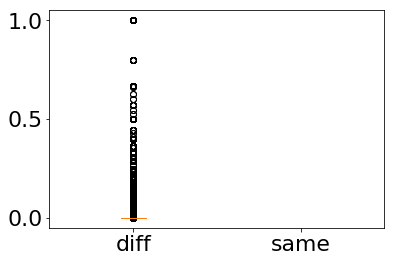

In [18]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

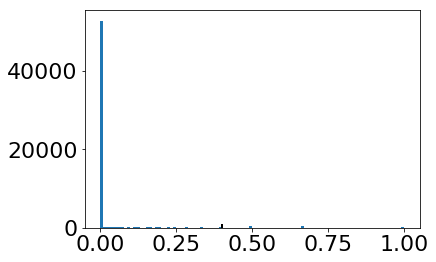

In [19]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [20]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('A13', 'GATGTCGA') ('F22', 'CGAGAATG') 0.4
('A13', 'GATGTCGA') ('L22', 'CATGCACA') 0.4
('A13', 'GATGTCGA') ('P16', 'TTAGGCAG') 0.4
('A13', 'GATGTCGA') ('P9', 'TTGATGGC') 0.4
('A15', 'CACAGCAT') ('D10', 'CGCTTGCT') 0.4
('A15', 'CACAGCAT') ('D13', 'TCTTGCTG') 0.5
('A15', 'CACAGCAT') ('F17', 'TAGACGCT') 0.5
('A15', 'CACAGCAT') ('F22', 'CGAGAATG') 0.6666666666666667
('A15', 'CACAGCAT') ('I13', 'AACCGCTT') 0.5
('A15', 'CACAGCAT') ('L22', 'CATGCACA') 0.6666666666666667
('A15', 'CACAGCAT') ('M5', 'TACCACGA') 1.0
('A15', 'CACAGCAT') ('N5', 'TTGTCCAC') 0.5
('A15', 'CACAGCAT') ('P16', 'TTAGGCAG') 0.6666666666666667
('A15', 'CACAGCAT') ('P7', 'GCGATATC') 0.8
('A15', 'CACAGCAT') ('P9', 'TTGATGGC') 0.6666666666666667
('A18', 'GAGTCCTG') ('F22', 'CGAGAATG') 0.4
('A18', 'GAGTCCTG') ('L22', 'CATGCACA') 0.4
('A18', 'GAGTCCTG') ('P16', 'TTAGGCAG') 0.4
('A18', 'GAGTCCTG') ('P9', 'TTGATGGC') 0.4
('A21', 'GGACCTTT') ('A5', 'ATTTAGCG') 0.5
('A21', 'GGACCTTT') ('A6', 'ATACAGAC') 0.4
('A21', 'GGACCTTT') ('B1

('D13', 'TCTTGCTG') ('A15', 'CACAGCAT') 0.5
('D13', 'TCTTGCTG') ('A21', 'GGACCTTT') 0.4
('D13', 'TCTTGCTG') ('A6', 'ATACAGAC') 0.5
('D13', 'TCTTGCTG') ('B22', 'AGTTGTGT') 0.6666666666666667
('D13', 'TCTTGCTG') ('C2', 'CTACGCTG') 0.5
('D13', 'TCTTGCTG') ('D10', 'CGCTTGCT') 0.4
('D13', 'TCTTGCTG') ('E10', 'CATCTCAC') 0.5
('D13', 'TCTTGCTG') ('F17', 'TAGACGCT') 0.5
('D13', 'TCTTGCTG') ('F22', 'CGAGAATG') 0.6666666666666667
('D13', 'TCTTGCTG') ('G2', 'CAAGGTGT') 0.5
('D13', 'TCTTGCTG') ('H13', 'GTCTCACA') 0.5
('D13', 'TCTTGCTG') ('I13', 'AACCGCTT') 0.5
('D13', 'TCTTGCTG') ('I15', 'AGAACAGG') 0.4
('D13', 'TCTTGCTG') ('I4', 'ACGATCCT') 0.6666666666666667
('D13', 'TCTTGCTG') ('J23', 'CTCTTTGC') 0.5
('D13', 'TCTTGCTG') ('J6', 'TAGCTACC') 0.5
('D13', 'TCTTGCTG') ('L13', 'GTCCAAAG') 0.4
('D13', 'TCTTGCTG') ('L22', 'CATGCACA') 0.6666666666666667
('D13', 'TCTTGCTG') ('L5', 'AGTCAGGA') 0.5
('D13', 'TCTTGCTG') ('M24', 'ATGGGCTT') 0.6666666666666667
('D13', 'TCTTGCTG') ('M5', 'TACCACGA') 0.5
('D13', 

('G16', 'GAGAACGA') ('L21', 'GCAAGAAG') 0.4
('G16', 'GAGAACGA') ('M23', 'TGGCACAA') 0.6666666666666667
('G17', 'GCTGTAAC') ('A21', 'GGACCTTT') 0.5
('G17', 'GCTGTAAC') ('G2', 'CAAGGTGT') 0.5714285714285714
('G17', 'GCTGTAAC') ('I11', 'CATGTCAC') 0.5
('G17', 'GCTGTAAC') ('J23', 'CTCTTTGC') 0.5454545454545454
('G17', 'GCTGTAAC') ('M21', 'CGAAAGCT') 0.5714285714285714
('G17', 'GCTGTAAC') ('N13', 'CACCATGT') 0.4
('G17', 'GCTGTAAC') ('N21', 'AGACAACC') 0.5714285714285714
('G17', 'GCTGTAAC') ('P8', 'ACGAACAC') 0.4444444444444444
('G2', 'CAAGGTGT') ('A21', 'GGACCTTT') 0.8
('G2', 'CAAGGTGT') ('A6', 'ATACAGAC') 0.5
('G2', 'CAAGGTGT') ('B19', 'GGATTGAC') 0.6666666666666667
('G2', 'CAAGGTGT') ('B22', 'AGTTGTGT') 0.6666666666666667
('G2', 'CAAGGTGT') ('C2', 'CTACGCTG') 0.5
('G2', 'CAAGGTGT') ('D13', 'TCTTGCTG') 0.5
('G2', 'CAAGGTGT') ('E10', 'CATCTCAC') 0.5
('G2', 'CAAGGTGT') ('E16', 'GAAACTGC') 0.6666666666666667
('G2', 'CAAGGTGT') ('F4', 'GGTTCTGA') 0.5
('G2', 'CAAGGTGT') ('G17', 'GCTGTAAC') 0.57

('J11', 'CATAGCTC') ('C16', 'AGGACTTA') 0.4
('J11', 'CATAGCTC') ('C6', 'GAAGACTT') 0.4
('J11', 'CATAGCTC') ('E3', 'GGACTACT') 0.4
('J11', 'CATAGCTC') ('F11', 'CTATAGGC') 0.4
('J11', 'CATAGCTC') ('M15', 'AGAGGTGA') 0.4
('J11', 'CATAGCTC') ('O5', 'AACCTGCT') 0.5714285714285714
('J19', 'ATGCTCTG') ('C24', 'CATGGGTT') 0.5
('J19', 'ATGCTCTG') ('D10', 'CGCTTGCT') 0.5
('J19', 'ATGCTCTG') ('G11', 'TGGTTGTC') 0.5
('J19', 'ATGCTCTG') ('H19', 'TGATCCTC') 0.4
('J19', 'ATGCTCTG') ('J3', 'TACCTGTC') 0.5
('J19', 'ATGCTCTG') ('M22', 'AATGGTGG') 0.6666666666666667
('J19', 'ATGCTCTG') ('N1', 'TGATCGGT') 0.5
('J23', 'CTCTTTGC') ('A21', 'GGACCTTT') 0.4444444444444444
('J23', 'CTCTTTGC') ('D13', 'TCTTGCTG') 0.5
('J23', 'CTCTTTGC') ('G17', 'GCTGTAAC') 0.5454545454545454
('J23', 'CTCTTTGC') ('G2', 'CAAGGTGT') 0.5
('J23', 'CTCTTTGC') ('I11', 'CATGTCAC') 0.4444444444444444
('J23', 'CTCTTTGC') ('M21', 'CGAAAGCT') 0.5
('J23', 'CTCTTTGC') ('N21', 'AGACAACC') 0.5
('J23', 'CTCTTTGC') ('P8', 'ACGAACAC') 0.4
('J3', '

('M20', 'CAGTCAGA') ('L1', 'ACAGAGCT') 0.6666666666666667
('M20', 'CAGTCAGA') ('M17', 'CCAACGTT') 1.0
('M20', 'CAGTCAGA') ('M4', 'GATGTACC') 1.0
('M20', 'CAGTCAGA') ('N3', 'CTCGTACT') 0.5
('M20', 'CAGTCAGA') ('P14', 'AACCGGAA') 0.5
('M21', 'CGAAAGCT') ('A21', 'GGACCTTT') 0.4
('M21', 'CGAAAGCT') ('B19', 'GGATTGAC') 0.6666666666666667
('M21', 'CGAAAGCT') ('E16', 'GAAACTGC') 0.6666666666666667
('M21', 'CGAAAGCT') ('F4', 'GGTTCTGA') 0.5
('M21', 'CGAAAGCT') ('G17', 'GCTGTAAC') 0.5714285714285714
('M21', 'CGAAAGCT') ('G2', 'CAAGGTGT') 0.5
('M21', 'CGAAAGCT') ('I11', 'CATGTCAC') 0.8
('M21', 'CGAAAGCT') ('J23', 'CTCTTTGC') 0.5
('M21', 'CGAAAGCT') ('L23', 'GTTCTTGC') 0.6666666666666667
('M21', 'CGAAAGCT') ('L3', 'TGATTCGC') 0.6666666666666667
('M21', 'CGAAAGCT') ('N13', 'CACCATGT') 0.5714285714285714
('M21', 'CGAAAGCT') ('N21', 'AGACAACC') 1.0
('M21', 'CGAAAGCT') ('N22', 'TGGCTTCA') 0.6666666666666667
('M21', 'CGAAAGCT') ('O18', 'GGTGACTA') 0.5
('M21', 'CGAAAGCT') ('P19', 'CAGAGAAG') 0.66666666

('O12', 'AGTTTCGG') ('N6', 'ATTGGACC') 0.6666666666666667
('O12', 'AGTTTCGG') ('O3', 'GATCCTGA') 0.6666666666666667
('O12', 'AGTTTCGG') ('O4', 'CCAGATGA') 0.6666666666666667
('O12', 'AGTTTCGG') ('P13', 'CAATGGTC') 0.5
('O12', 'AGTTTCGG') ('P5', 'CCTTTGAC') 0.6666666666666667
('O17', 'GTGCTAGT') ('L1', 'ACAGAGCT') 0.6666666666666667
('O17', 'GTGCTAGT') ('M8', 'GTATGCAC') 1.0
('O18', 'GGTGACTA') ('A21', 'GGACCTTT') 0.4
('O18', 'GGTGACTA') ('B19', 'GGATTGAC') 0.6666666666666667
('O18', 'GGTGACTA') ('C21', 'CCGAGTAC') 0.6666666666666667
('O18', 'GGTGACTA') ('E16', 'GAAACTGC') 0.6666666666666667
('O18', 'GGTGACTA') ('F15', 'ATAGGAGC') 0.4
('O18', 'GGTGACTA') ('F17', 'TAGACGCT') 0.5
('O18', 'GGTGACTA') ('F4', 'GGTTCTGA') 0.5
('O18', 'GGTGACTA') ('G1', 'CGGTGTTT') 0.6666666666666667
('O18', 'GGTGACTA') ('G2', 'CAAGGTGT') 0.5
('O18', 'GGTGACTA') ('H12', 'CAAAGTGG') 0.4
('O18', 'GGTGACTA') ('I11', 'CATGTCAC') 0.4
('O18', 'GGTGACTA') ('I22', 'TGGTGAGT') 0.5
('O18', 'GGTGACTA') ('L16', 'TCGTCCTT'

('P8', 'ACGAACAC') ('L23', 'GTTCTTGC') 0.4
('P8', 'ACGAACAC') ('L3', 'TGATTCGC') 0.4
('P8', 'ACGAACAC') ('M21', 'CGAAAGCT') 0.6666666666666667
('P8', 'ACGAACAC') ('N13', 'CACCATGT') 0.6666666666666667
('P8', 'ACGAACAC') ('N21', 'AGACAACC') 0.6666666666666667
('P8', 'ACGAACAC') ('N22', 'TGGCTTCA') 0.4
('P8', 'ACGAACAC') ('P19', 'CAGAGAAG') 0.4
('P8', 'ACGAACAC') ('P2', 'ATCGACGA') 0.4
('P8', 'ACGAACAC') ('P4', 'CCCTAGTA') 0.4444444444444444
('P9', 'TTGATGGC') ('A13', 'GATGTCGA') 0.4
('P9', 'TTGATGGC') ('A15', 'CACAGCAT') 0.6666666666666667
('P9', 'TTGATGGC') ('A18', 'GAGTCCTG') 0.4
('P9', 'TTGATGGC') ('D10', 'CGCTTGCT') 0.5
('P9', 'TTGATGGC') ('D13', 'TCTTGCTG') 0.6666666666666667
('P9', 'TTGATGGC') ('F17', 'TAGACGCT') 0.6666666666666667
('P9', 'TTGATGGC') ('F22', 'CGAGAATG') 1.0
('P9', 'TTGATGGC') ('I13', 'AACCGCTT') 0.6666666666666667
('P9', 'TTGATGGC') ('L22', 'CATGCACA') 1.0
('P9', 'TTGATGGC') ('M5', 'TACCACGA') 0.6666666666666667
('P9', 'TTGATGGC') ('N5', 'TTGTCCAC') 0.666666666666

In [21]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 0.0002674869600106655
max value: 1.0
Wrote VASAseq-CDR3-IGH-highlighted.pdf to disk


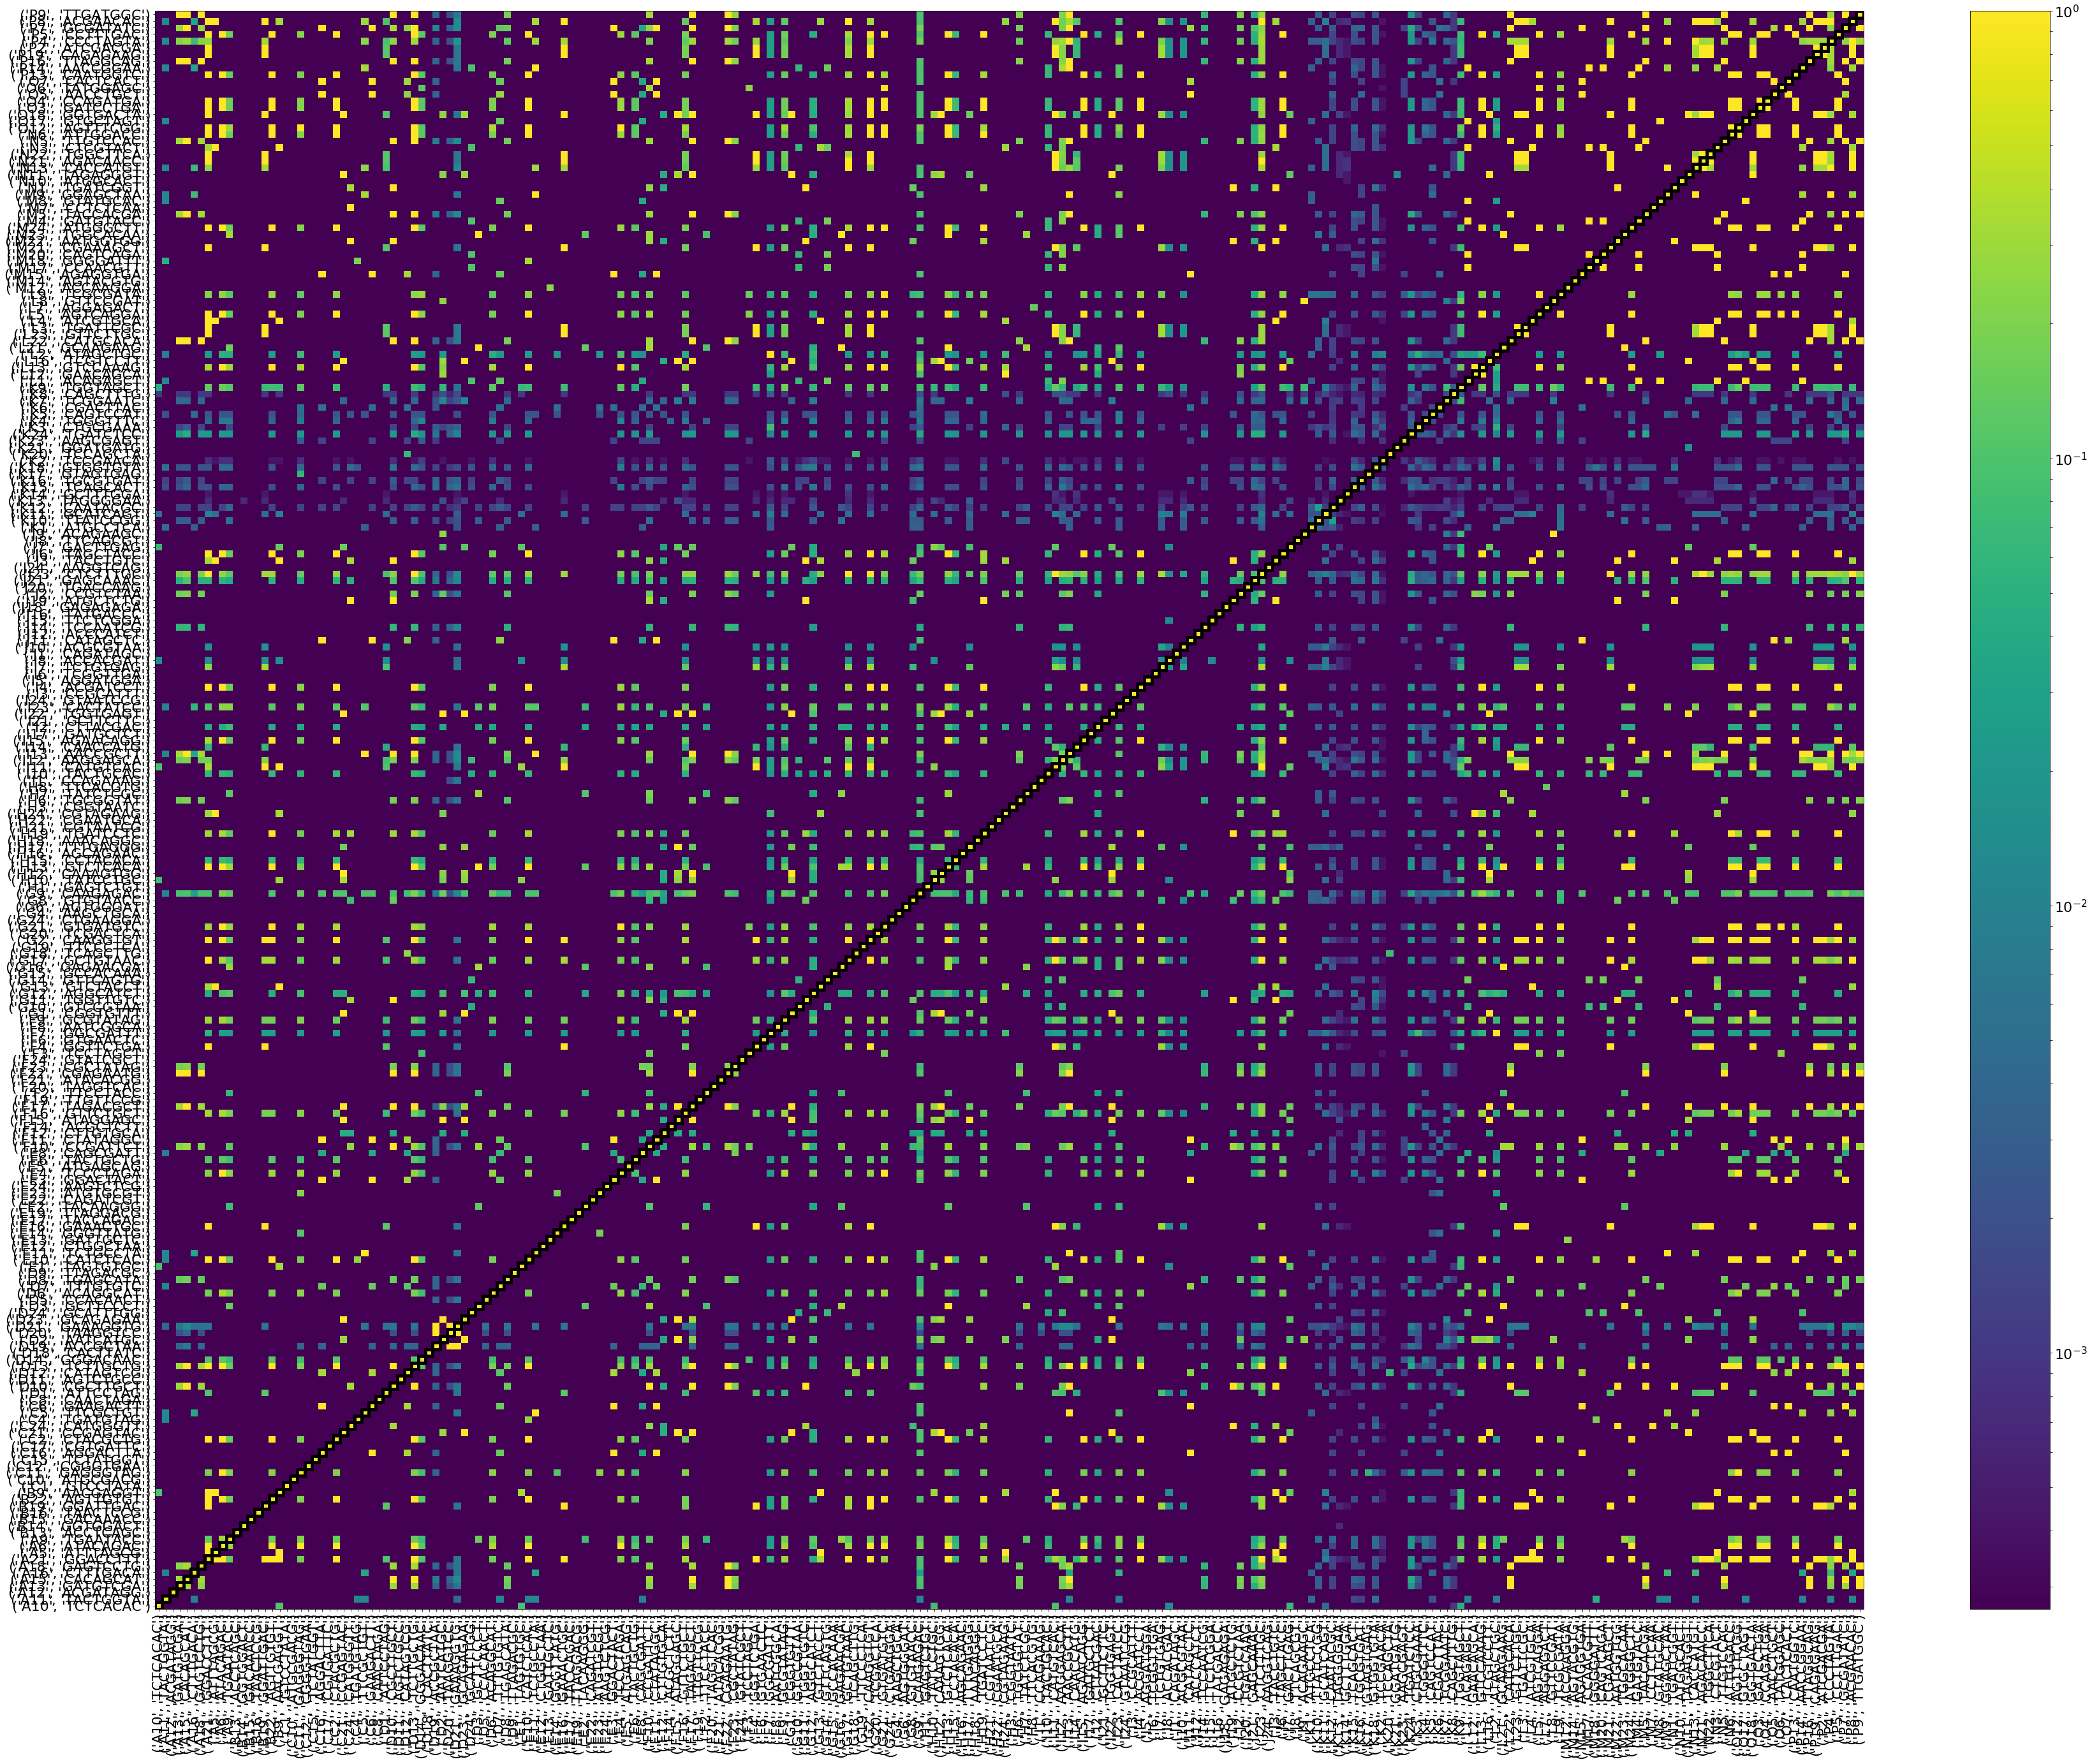

In [22]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)